# Time Series Tutorial (from https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)

Time series is typically non-stationary data, like economic, weather, stock price, or retail sales. This tutorial will go through  different approaches for forecasting retail sales time series.

## The Data

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
#read in the data and save columns as furniture
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [4]:
furniture['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [5]:
furniture['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

In [6]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

## Data Preprocessing

Perform preprocessing to remove columns we don't need, check missing/null values, and group sales and the order date together.

In [7]:
#getting rid of some columns that we do not need
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

#no null values
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [9]:
#group by the data and also include the number of sales
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
#print out the first element
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


## Indexing with time series data

In [10]:
#set the order date as the index
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [11]:
#need to average daily sales data because the datetime data is a little tricky to work with
y = furniture['Sales'].resample('MS').mean()

In [12]:
#print out the data
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Visualizing furniture sales time series data

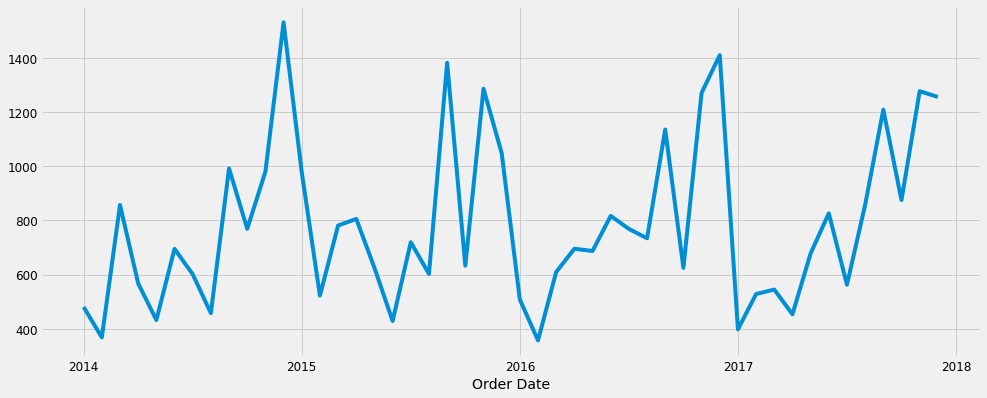

In [13]:
#plot the daily sales vs orderdate graph 
y.plot(figsize=(15, 6))
plt.show()

In the above graph we can see that there are some patterns. For example, sales tend to spike towards the end of each year during the Holidays. 

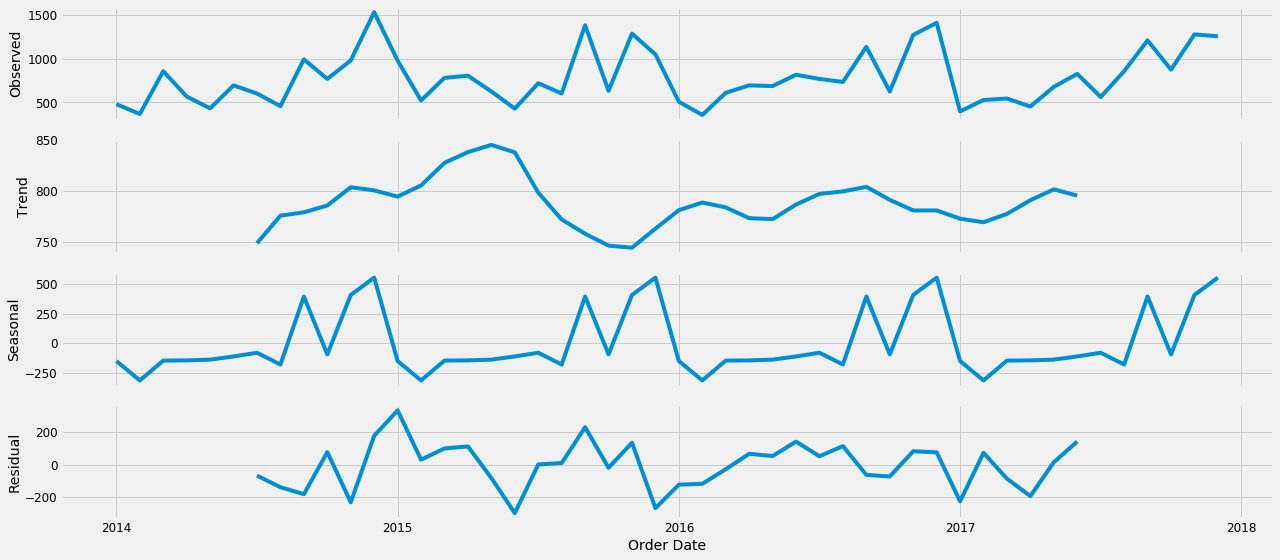

In [14]:
#plot a decompostion graph, which decomposes our time series into 3 components: trend, seasonality, and noise
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The graphs above show that the sales of furniture is unstable, and there is a fair amount of seasonality.

## Time series forecasting with ARIMA (Autoregressive Integrated Moving Average)

Autoregressive Integrated Moving Average, or ARIMA, is a forecasting method for univariate time series data. SARIMA is used for seasonal data.

In [15]:
#p, d, q are the three parameters for ARIMA. They represent for seasonality, trend and noise.
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#print out examples of parameter combinations for Seasonal ARIMA
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [19]:
#goes through all parameters  in arima
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            #finds the sarima (seasonal ARIMA) for all dates
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            #prints out different parameter combinations and the AIC, which is Akaike Information Critera
            #AIC is typically used to measure a statistical model. It measures fit and simplicity
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1481.388394566794
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1038.2112778736594
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758122
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2898.655912211657
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809126
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5655707546977
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1455131464.3671336
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468646
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1265.3908715914945
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.7889663004408
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1246.890028424191
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817575
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2578.2754374558276
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482528
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.18329774425735
ARI

## Fitting the ARIMA model

In [20]:
#fit your model using SARIMAX and print the results
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

#coefficents, standard error, z score, probability greater than z score ,CI
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


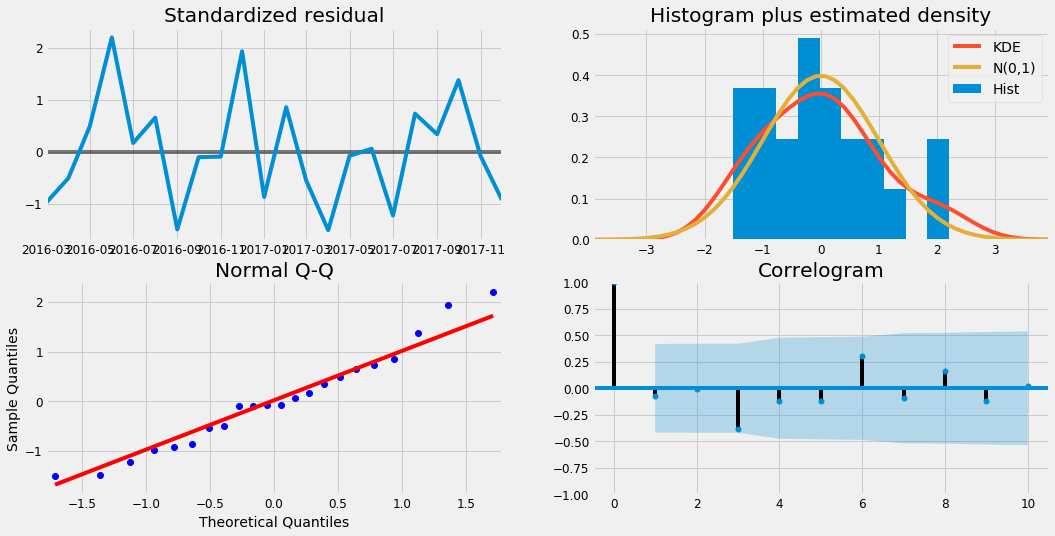

In [21]:
#print the diagnositcs to see if there are any major errors in the model
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Although not perfect our model seems to be pretty good. The graphs all look fairly normally distributed.

## Validating forecasts

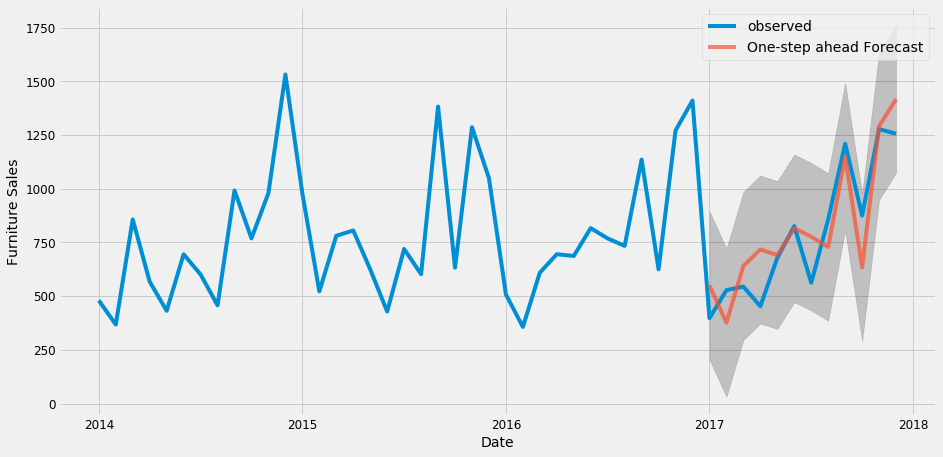

In [22]:
#based off the SARIMA model, predict all of the 2017 sales
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

#plot sales vs dates, with the predicted forcast and compare it against the actual
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

The results above are pretty accurate based off the graph.

In [23]:
#get the mean for the predictd
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error (the average of the squared errors)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.57


In [24]:
#print the root mean squared error
#root mean squared error means our moedel was able to predict the average daily furniture 
#sales in the test set within 151.64 of the real sales
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


## Producing and visualizing forecasts

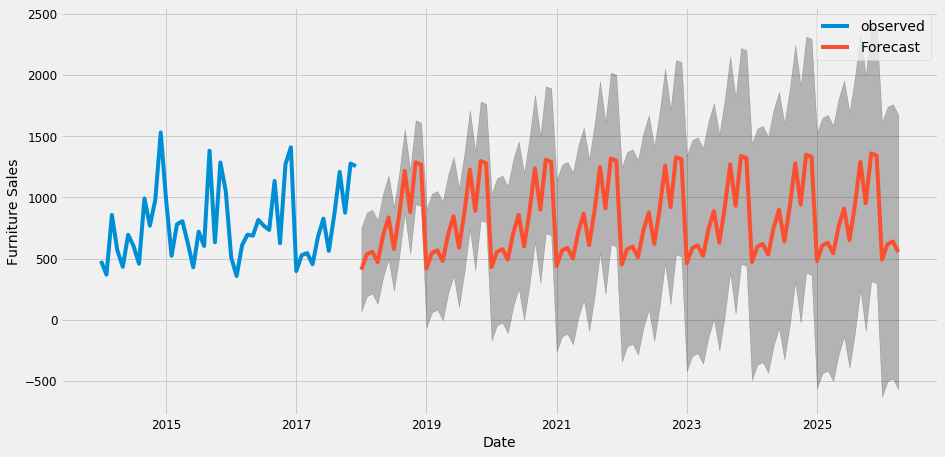

In [25]:
#predict the potential future sales and include the confidence interval
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

As we can see the predictions are more or less the same and farily accurate, but the confidence interval keeps increasing as time goes on.

## Time Series of Furniture vs. Office Supplies

Now we are going to do a time series of the furniture vs Office Supplies.

In [26]:
#get the shape of furniture and the office supplies
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

## Data Exploration

In [27]:
#drop irrevelent columns
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

#sort by order date
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

#group by order date and sales
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

In [28]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [29]:
office.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430


In [30]:
#set the index like above
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

#get the mean, since the data is tricky
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

#create a dataframe for furniture and office
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

#merge both dataframes because we want to compare both results in the same plot
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


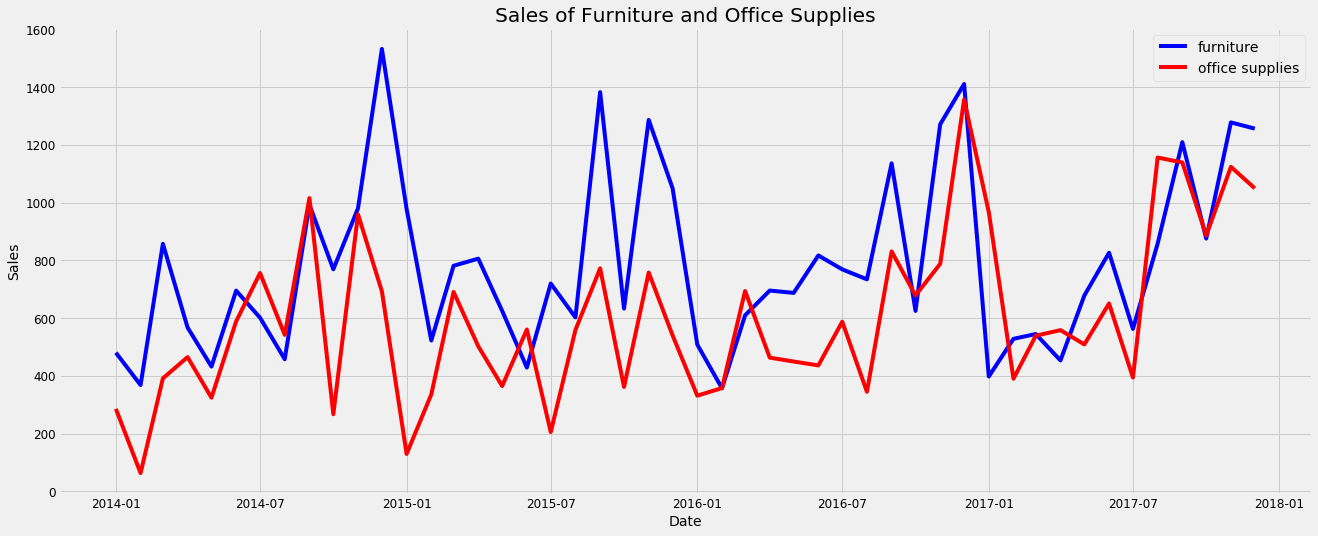

In [31]:
#plot the figure: sales for office and furniture vs date
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

The graph shows a similar trend, that there is a seasonal uptick in office supplies too. However, furniture in most months produces more sales.

In [32]:
#find the first instance where office sales are greater than furniture sales
first_date = store.ix[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


## Time Series Modeling with Prophet

Prophet is a forcasting tool used for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. We will create a model using Prophet.

In [38]:
from fbprophet import Prophet

#fit the prophet model on furniture
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

#fit the prophet model on office supplies
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

#use the model to predict furniture
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

#use the model to predcit office supplies
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

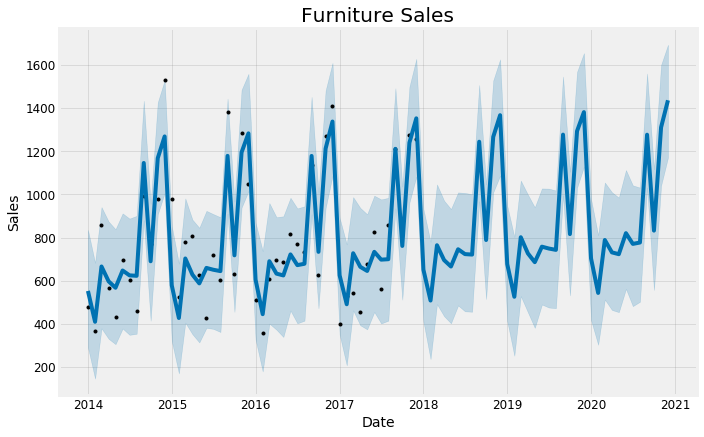

In [39]:
#plot the figure of the furniture sales forcast
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

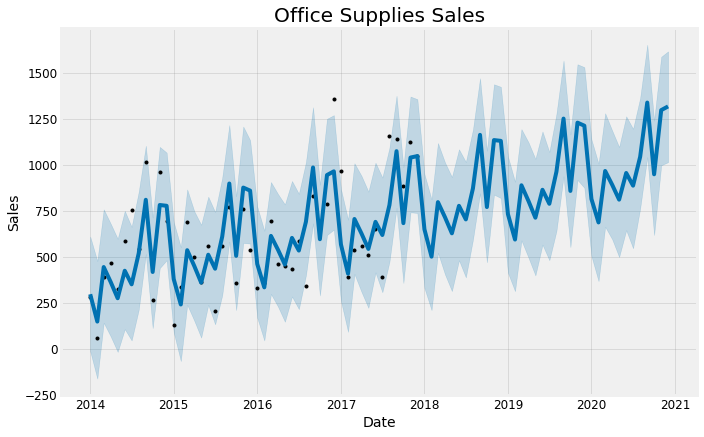

In [40]:
#plot the office supplies forecast
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

## Compare Forecasts

In [41]:
#We want to join both forcasts in order to compare
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

#merge both
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

#rename the columns and drop some
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_trend_lower,furniture_trend_upper,furniture_yhat_lower,furniture_yhat_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_multiplicative_terms,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_yhat
0,2014-01-01,731.350832,731.350832,731.350832,290.148673,835.731663,-178.935009,-178.935009,-178.935009,0.0,...,-132.487041,-132.487041,-132.487041,0.0,0.0,0.0,-132.487041,-132.487041,-132.487041,297.861111
1,2014-02-01,733.442293,733.442293,733.442293,145.719695,682.843314,-324.072006,-324.072006,-324.072006,0.0,...,-288.224139,-288.224139,-288.224139,0.0,0.0,0.0,-288.224139,-288.224139,-288.224139,149.596082
2,2014-03-01,735.331355,735.331355,735.331355,378.839415,941.395673,-69.359319,-69.359319,-69.359319,0.0,...,0.847373,0.847373,0.847373,0.0,0.0,0.0,0.847373,0.847373,0.847373,445.416558
3,2014-04-01,737.422817,737.422817,737.422817,330.378240,874.489427,-140.383817,-140.383817,-140.383817,0.0,...,-89.140087,-89.140087,-89.140087,0.0,0.0,0.0,-89.140087,-89.140087,-89.140087,362.901168
4,2014-05-01,739.446812,739.446812,739.446812,305.463440,838.456661,-172.281896,-172.281896,-172.281896,0.0,...,-183.186206,-183.186206,-183.186206,0.0,0.0,0.0,-183.186206,-183.186206,-183.186206,276.086083


## Visualizing the trend and the forecast

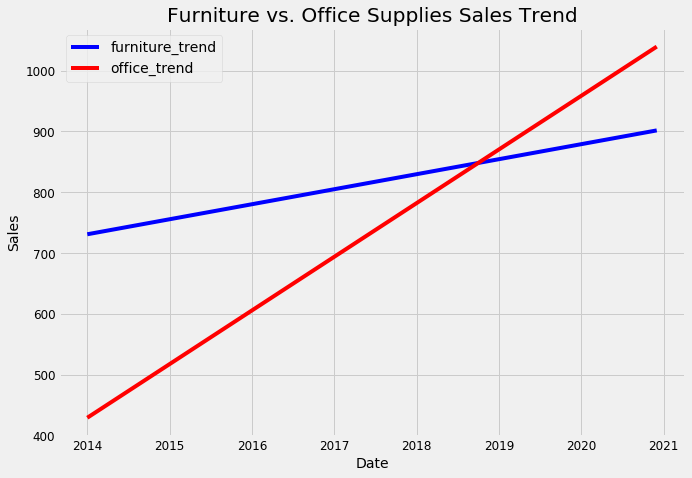

In [42]:
#plot the merged graphs for a sales vs date to see an overall linear trend in sales
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

We see an overall upward in both sales, but we see a faster increase in office sales.

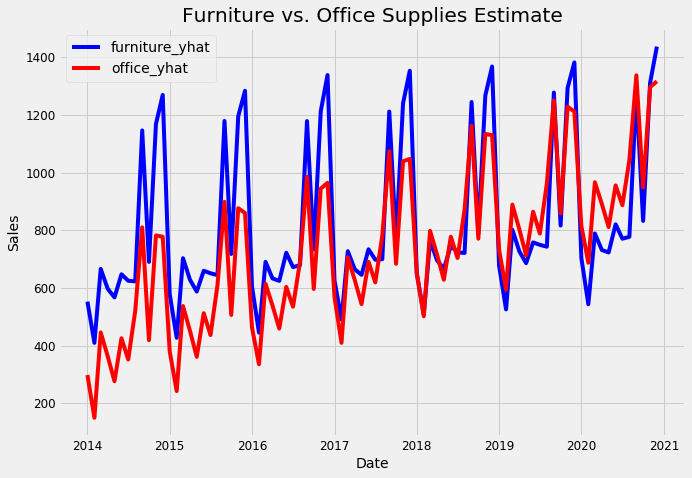

In [43]:
#plot the merged graphs, but shows the spikes in each month for the seasonal data
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

## Trends and Patterns

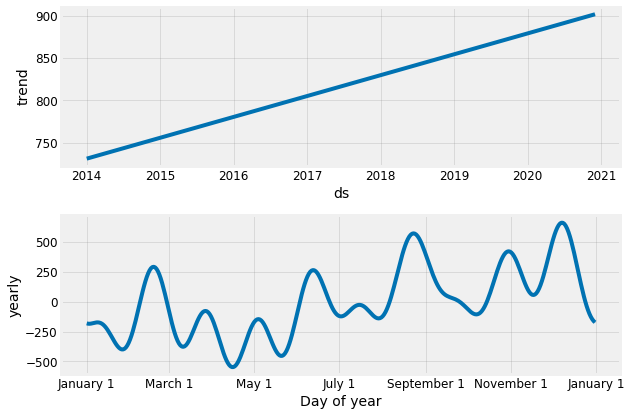

In [44]:
#plot the trends and patterns in furniture data
#split the graphs
furniture_model.plot_components(furniture_forecast);

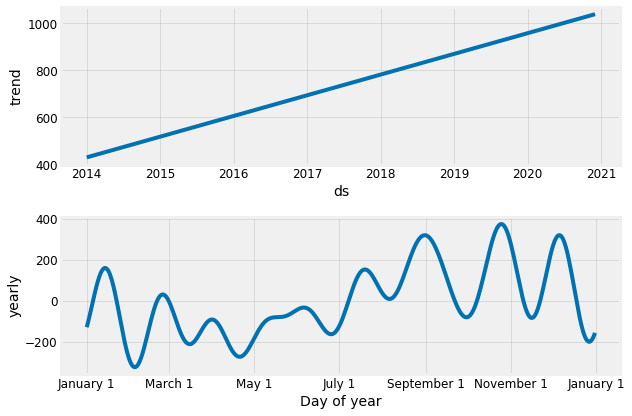

In [45]:
#plot the trends and patterns in furniture data.
#split the graphs
office_model.plot_components(office_forecast);

We see that the overall growth for both is positive, with office supplies increasing at a faster rate. We aslo see a slight dip in sales for the month of April in both.